# Preventing Overfitting in Random Forest Estimate
In this notebook, we will try to prevent overfitting of our random forest estimate. We will quickly copy all the code over from Simple Converge into here.

## Sampling Code

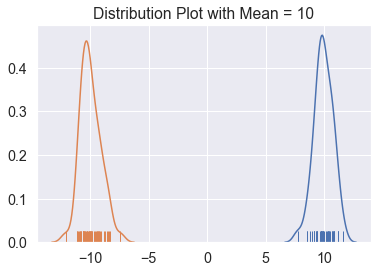

In [2]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100, 10, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = 10")
plt.show()

## Original Algorithm Code

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import entropy

def estimate_conditional_entropy(X, y, n_trees = 10, max_depth = None, bootstrap = False):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = max_depth)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

X, y = get_sample(400, 0, 1)
estimate_conditional_entropy(np.array(X).reshape(-1, 1), y, 10, 4)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


0.6233304992097379

### Ok, now that the code has been imported. We will revisit the case where all entropies drop to 0.
Remember that this happens when we do not set a maximum depth to our trees

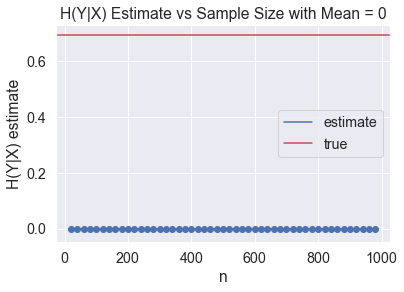

In [5]:
np.warnings.filterwarnings('ignore')

def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*20 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(estimate_conditional_entropy(np.array(X).reshape(-1, 1), y, 20, None, bootstrap = False))
    return sample_sizes, conditional_entropy


sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

## Test Number 1: Bag at 63%
We will change our classifier to use the Bagging classifier of Decision trees. Use all the features but only 63% of samples in each tree

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

def estimate_conditional_entropy(X, y, n_trees = 100, max_samples = 1., max_features = 1., depth = None):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth), n_estimators = n_trees, max_samples= max_samples, max_features= max_features, oob_score = True, bootstrap = True)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

X, y = get_sample(400, 0, 1)
estimate_conditional_entropy(np.array(X).reshape(-1, 1), y, 500, .63, depth = 4)

0.6882075306635298

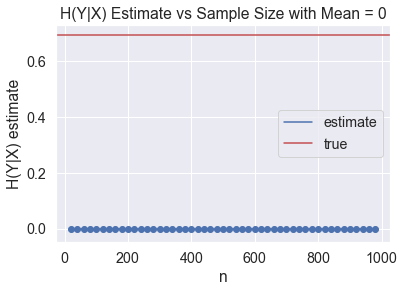

In [22]:
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*20 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(estimate_conditional_entropy(np.array(X).reshape(-1, 1), y, 500, .63, depth = 1000))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(5)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

Didn't work. What if we switch impurity to entropy?

In [88]:
def estimate_conditional_entropy_ent(X, y, n_trees = 10, max_depth = None, bootstrap = False):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = max_depth, random_state = 0, criterion = "entropy")
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

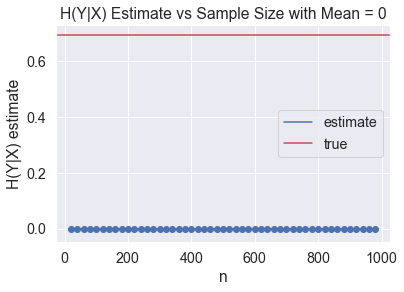

In [89]:
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*20 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(estimate_conditional_entropy_ent(np.array(X).reshape(-1, 1), y, 500))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.69315, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

## Another try to get bagging working correctly on random forest

In [6]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 500, max_samples = .63, bootstrap = True, depth = 4):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        #print(node_counts)
        #print(X[unsampled_indices])
        # get counts for out of bag samples
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[unsampled_indices])])
        #print(partition_counts)
        # get probability for out of bag samples
        class_probs = tree.predict_proba(X[unsampled_indices])
        # find total elements for out of bag samples
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[unsampled_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .63)

0.692812368307697

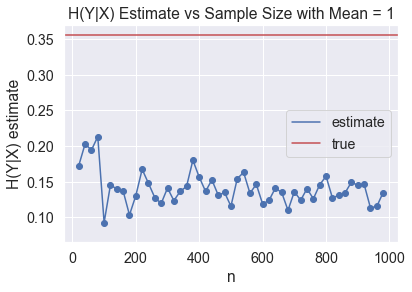

In [11]:
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*20 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 200, .63, depth = None))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

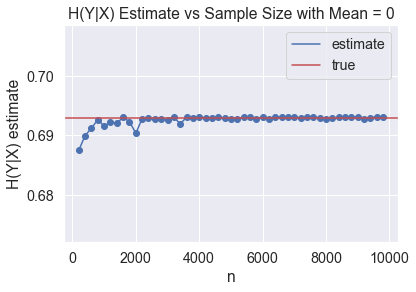

In [15]:
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 200, .63, depth = 4))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(0)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.693, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 0")
plt.show()

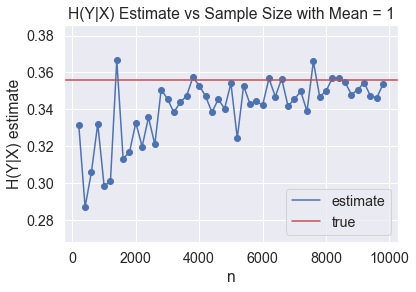

In [8]:
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    sample_sizes = [i*200 for i in range(1, 50)]
    for elem in sample_sizes:
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 1000, .63, depth = 4))
    return sample_sizes, conditional_entropy

sample_sizes, cond_entropy = get_cond_entropy_vs_n(1)
plt.scatter(sample_sizes, cond_entropy)
line_est, = plt.plot(sample_sizes, cond_entropy, label = "estimate")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.legend(handles=[line_est, line_true])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()

Some further investigation suggests that we might still be overfitting

In [ ]:
model = BaggingClassifier(DecisionTreeClassifier(), 
                              n_estimators = 500, 
                              max_samples= .63, 
                              bootstrap = True)
model.fit(X, y)
class_counts = np.zeros((X.shape[0], model.n_classes_))
for tree in model:
    unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
    node_counts = tree.tree_.n_node_samples
    partition_counts = np.asarray([node_counts[x] for x in tree.apply(X)])
    #print(partition_counts[5])
    class_probs = tree.predict_proba(X)
    #print(class_probs[5])
    elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
    i = 0
    for elem in elems:
        class_counts[i] += elem
        i += 1
    print(class_counts[0])
    #if 0 in unsampled_indices:
        #print(elems[0])
    
probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
#print(probs[0])
entropies = -np.sum(np.log(probs)*probs, axis = 1)
entropies = np.nan_to_num(entropies)
print(np.mean(entropies))
np.warnings.filterwarnings('ignore')

#rf_entropy_estimate_bagging(X, y, 500, .63)

Averaging these entropies won't balance themselves out. We would ideally like to see almost all .5-.5 splits. But instead, we get a lot lower entropies.

Since each tree is still overfitting on whatever it was trained on, and we are only using the posterior distribution given the data it was trained on, we are still using an overfitted posterior distribution.

For example, in this case, since X provides no information on Y, ideally we would expect 50% of each class in each paritition. However, instead we will get .9 of class 0 and .1 of class 1. And in another partition, we might get .1 of class 0 and .9 of class 1. This may be "robust" in the sense that the results should balance out. However, since what we want to consider is entropy, our results will not in fact show this balancing (.1 and .9 entropy is same as .9 and .1). 

We cannot just average the conditional probability estimates since that would just get .5 always.

In [14]:
import pandas as pd
df = pd.DataFrame(data = probs, columns = ["P(Y = 0 | X = x)", "P(Y = 1 | X = x)"] )

In [16]:
df.sample(10)

,P(Y = 0 | X = x),P(Y = 1 | X = x)
7,0.445652,0.554348
54,0.783019,0.216981
28,0.025641,0.974359
34,0.750000,0.250000
76,0.851485,0.148515
11,0.435897,0.564103
55,0.381443,0.618557
25,0.178218,0.821782
62,0.154930,0.845070
63,0.550725,0.449275


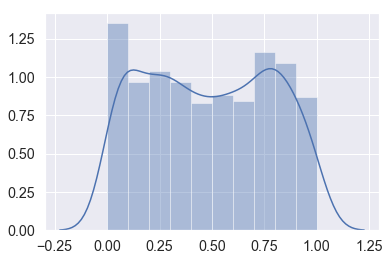

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(probs[:, 0]);
